In [20]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [21]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [22]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

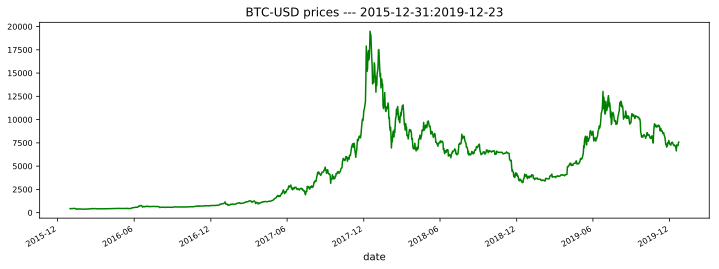

In [23]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/BTC.csv')

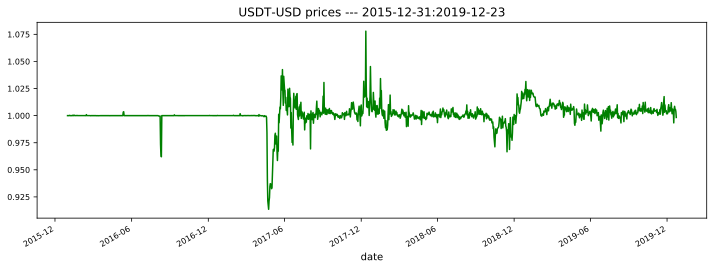

In [24]:
download_csv_data(ticker='USDT-USD', 
                  start_date='2015-12-31', 
                  end_date='2019-12-23', 
                  freq='daily', 
                  path='data/USDT.csv')

In [25]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'USDT']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [26]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                   open        close
date                                
2019-12-19  7202.844238  7202.844238
2019-12-20  7218.816406  7218.816406
2019-12-21  7191.158691  7191.158691
2019-12-22  7511.588867  7511.588867
2019-12-23  7580.127441  7580.127441
                open     close
date                          
2019-12-19  1.008569  1.008569
2019-12-20  1.005842  1.005842
2019-12-21  1.005758  1.005758
2019-12-22  1.003887  1.003887
2019-12-23  0.998302  0.998302


In [27]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1454 (major_axis) x 2 (minor_axis)
Items axis: BTC to USDT
Major_axis axis: 2015-12-31 00:00:00+00:00 to 2019-12-23 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [28]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,USDT
BTC,1.000000,0.185776
USDT,0.185776,1.000000


# Построение границы эффективности

###  Задаем стартовые параметры

In [29]:
# set the number of combinations for imaginary portfolios
num_portfolios = 10
COMMISSION = 0.0007
REBALANCE_PERIOD = 63
DELTA = 0.5

### Определяем стартовые переменные

In [30]:
num_assets = len(TIKERS)

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

#set random seed for reproduction's sake
np.random.seed(101)

In [31]:
# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in tqdm(range(num_portfolios)):
    weights = np.random.random(num_assets)     # добавил "+1"  (учитывем еще и cash)
    weights /= np.sum(weights)#/(1-CASH)
    WEIGHTS = weights
    
    def initialize(context):
    
        context.set_commission(commission.PerDollar(cost=COMMISSION))

        set_benchmark(symbol('BTC'))

        context.tikers = TIKERS
        context.assets = [context.symbol(symbol) for symbol in context.tikers]

        context.weights = WEIGHTS
        context.n_assets = len(context.assets)

        context.window = 1

        context.rebalance_count = 0
        context.time = 0
        
    
    def handle_data(context, data):
    
        if context.time == 0:

            # extract prices
            prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

            # submit orders
            for i, asset in enumerate(context.assets):
                order_target_percent(asset, context.weights[i])

            context.time += 1
    
        else:
            for i, asset in enumerate(context.assets):
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i])/context.weights[i] > DELTA:
                    order_target_percent(asset, context.weights[i])
                    context.rebalance_count += 1

            context.time += 1
    
    perf = zipline.run_algorithm(start=datetime(2015, 12, 31, 0, 0, 0, 0, pytz.utc),
                                  end=datetime(2019, 12, 20, 0, 0, 0, 0, pytz.utc),
                                  initialize=initialize,
                                  capital_base=100000000,
                                  handle_data=handle_data,
                                  data=panel)

    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
    sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
    port_returns.append(qf.get_performance_summary(returns).annualized_returns)
    port_volatility.append(qf.get_performance_summary(returns).annual_volatility)
    stock_weights.append(WEIGHTS)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [21:36<00:00,  2.59s/it]


# Визуализация результатов

In [32]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [38]:
df.head(500)

,Returns,Volatility,Sharpe Ratio,BTC Weight,USDT Weight
0,0.663171,0.402822,1.463999,0.475039,0.524961
1,0.177320,0.128267,1.336897,0.142374,0.857626
2,0.497003,0.388437,1.232533,0.451085,0.548915
3,0.306268,0.212949,1.361272,0.255682,0.744318
4,0.920560,0.719234,1.265997,0.791615,0.208385
5,0.711656,0.588384,1.207268,0.611488,0.388512
6,0.236900,0.161891,1.394085,0.188004,0.811996
7,0.932693,0.718368,1.275439,0.806022,0.193978
8,0.155025,0.111947,1.343485,0.121613,0.878387
9,0.877528,0.712024,1.239696,0.725199,0.274801


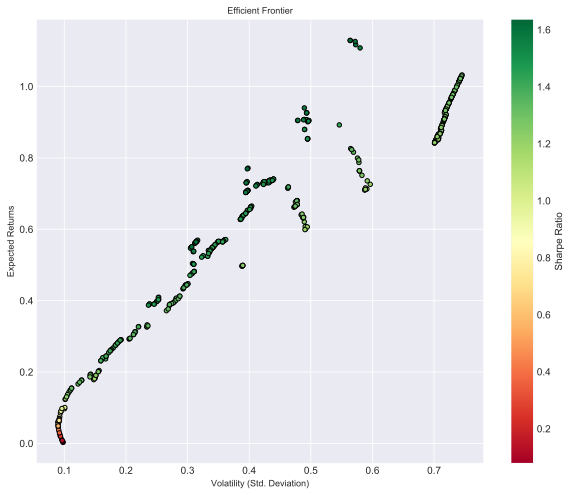

In [34]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
#fig, ax = plt.subplots()
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', 
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 9)
plt.ylabel('Expected Returns', fontsize = 9)
plt.title('Efficient Frontier', fontsize = 9)
plt.show()

# Оптимальное соотношение активов

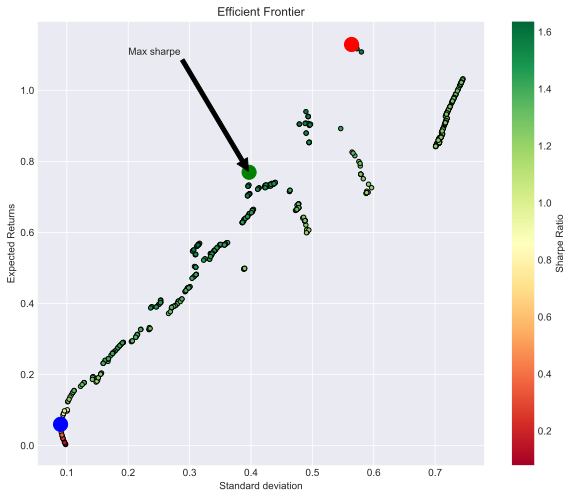

In [39]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_portfolio = df.loc[df['Returns'] == max_returns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='o', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.scatter(x=max_return_portfolio['Volatility'], y=max_return_portfolio['Returns'], c='red', marker='o', s=200 )

plt.annotate('Max sharpe', xy=(sharpe_portfolio['Volatility'], sharpe_portfolio['Returns']), xytext=(0.2, 1.1), 
             arrowprops=dict(facecolor='black', shrink=0.01))

plt.xlabel('Standard deviation')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [36]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)
print(max_return_portfolio.T)

                    76
Returns       0.059813
Volatility    0.089804
Sharpe Ratio  0.691713
BTC Weight    0.048906
USDT Weight   0.951094
                   213
Returns       0.769339
Volatility    0.396944
Sharpe Ratio  1.635482
BTC Weight    0.490692
USDT Weight   0.509308
                   202
Returns       1.129074
Volatility    0.563856
Sharpe Ratio  1.619301
BTC Weight    0.658101
USDT Weight   0.341899
